In [1]:
!pwd
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

import sys
from collections import Counter, defaultdict
import numpy as np
import scipy.stats, scipy.spatial, scipy.signal
import os
import json
from path import Path; Path.stem = Path.namebase
from natsort import natsorted
import itertools
from tqdm import tqdm
from collections import OrderedDict

from ppm3d import Cluster, align, AlignedData, Model
from motifextraction import load_cns
from motifextraction.utils import get_norm_factors

/home/jjmaldonis/repos/release/motifextraction/examples/notebooks


In [2]:
font = {
    'family': 'normal',
    'weight': 'normal',
    'size'  : 8
}
matplotlib.rc('text', usetex=False)
matplotlib.rc('font', **font)

cm2in = 2.54
in2cm = 1. / cm2in
print(cm2in, in2cm)
golden_ratio = 8./6. #1.61803398875

def compute_fig_size(width_in_cm):
    width_in_in = width_in_cm / cm2in
    height_in_in = width_in_in / golden_ratio
    return width_in_in, height_in_in

print(compute_fig_size(9))

2.54 0.39370078740157477
(3.543307086614173, 2.65748031496063)


In [3]:
MARKER_STYLES = ["o", "D", "x", "s", "v", "^", "<", ">", "p", "8",
                 "*", "P", "h", "d"]

In [4]:
temperature_path = Path("../")
T = 0
data_path = temperature_path / f"{T}" / Path("metallic_glass/data")
cluster_path = data_path / "clusters"
motif_path = Path("../motifextraction/examples/motifextraction/metallic_glass/data/averaged/")
motif_errors_path = data_path / "motif_errors"

In [5]:
cluster_cns = load_cns(cluster_path).astype(int)
NCLUSTERS = len(cluster_cns)
print(NCLUSTERS)

Loading cns...
9826


In [6]:
# Chemical analysis
center_atoms = [None for _ in range(NCLUSTERS)]
for i in range(NCLUSTERS):
    fn = cluster_path / f'{i}.xyz'
    with open(fn) as f:
        last_line = f.readlines()[-1].strip()
        center_atoms[i] = last_line.split()[0]

center_atoms = np.array(center_atoms)
print(dict(Counter(center_atoms)))
print({key: round(100.*value/NCLUSTERS,2) for key, value in Counter(center_atoms).items()})

{'Ni': 3895, 'Zr': 5931}
{'Ni': 39.64, 'Zr': 60.36}


/home/group/anaconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


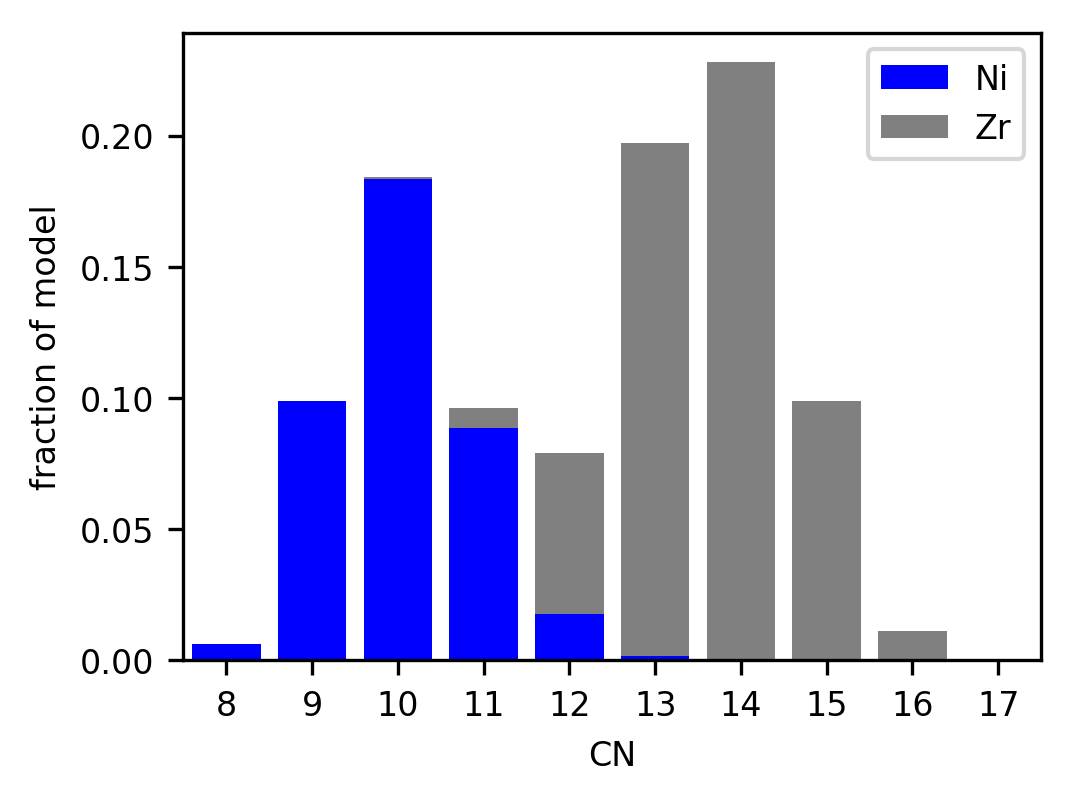

In [7]:
fig = plt.figure(figsize=compute_fig_size(9.2), dpi=300)

totals = Counter()
for t, color in zip(['Ni', 'Zr'], ['blue', 'grey']):
    zr = np.where(center_atoms == t)
    #print(Counter(cluster_cns[zr]))
    zrc = Counter(cluster_cns[zr])
    zrx, zry = zip(*zrc.most_common())
    zry = np.array(zry) / NCLUSTERS
    
    bottom = [totals[x] for x in zrx]
    plt.bar(zrx, zry, bottom=bottom, color=color, label=f'{t}')
    for x, y in zip(zrx, zry):
        totals[x] += y

plt.xlabel("CN")
plt.ylabel("fraction of model")
plt.xlim([min(cluster_cns)-0.5, max(cluster_cns)+0.5])
plt.xticks(range(min(cluster_cns), max(cluster_cns)+1))
plt.legend(loc='upper right')
plt.tight_layout()
#plt.savefig("CN_distribution.png", dpi=fig.dpi)
plt.show()

In [8]:
# Load motifs
# The motifs I used here were just to do some basic testing.

motif_fns = natsorted(motif_path.glob("*.xyz"))
motif_fns.sort(key=lambda fn: (len(fn.stem.split("_")[0]), fn))
motif_fns = [f for f in motif_fns if not f.stem.startswith("ignore")]
NMOTIFS = len(motif_fns)
print(NMOTIFS)
motifs = [Cluster(filename=fn) for fn in motif_fns]

for motif in motifs:
    print(motif.filename.stem, motif.CN)

17
Z12_FK 12
averaged_0 13
averaged_1 12
averaged_11 12
averaged_12 11
averaged_13 9
averaged_14 14
averaged_15 14
averaged_16 15
averaged_1600K_CN10_manual 10
averaged_1600K_CN9_manual 9
averaged_2 16
averaged_3 15
averaged_6 14
averaged_7 10
averaged_8 12
averaged_9 14


In [9]:
motifs_by_CN = defaultdict(list)
for motif in motifs:
    motifs_by_CN[motif.CN].append(motif)

In [10]:
alphabet = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L']

_cns = Counter()
for motif in motifs:
    i = _cns[motif.CN]
    letter = motif.filename.stem.split('_')[0]
    aletter = alphabet[i]
    motif.label = f'${motif.CN}_{aletter}$'
    _cns[motif.CN] += 1
    print(motif.label, motif.filename.stem)

$12_A$ Z12_FK
$13_A$ averaged_0
$12_B$ averaged_1
$12_C$ averaged_11
$11_A$ averaged_12
$9_A$ averaged_13
$14_A$ averaged_14
$14_B$ averaged_15
$15_A$ averaged_16
$10_A$ averaged_1600K_CN10_manual
$9_B$ averaged_1600K_CN9_manual
$16_A$ averaged_2
$15_B$ averaged_3
$14_C$ averaged_6
$10_B$ averaged_7
$12_D$ averaged_8
$14_D$ averaged_9


In [11]:
motifs = natsorted(motifs, key=lambda motif: motif.label)

In [12]:
# Set motif.data_path
for motif in motifs:
    dp = Path(f"../{T}/metallic_glass/data")
    motif.data_path = dp

In [13]:
# Load the motif errors
def get_motif_errors(motif, T):
    stem = motif.filename.stem
    error_path = motif.data_path.format(T=T) / f"motif_errors/{stem}_errors.npy"
    return np.load(error_path)

with open("../motifextraction/examples/motifextraction/metallic_glass/data/norm_factors.json") as f:
    nf = json.load(f)
for motif in sorted(motifs, key=lambda m: m.CN):
    print(motif.CN, motif.filename.stem, motif.vp_index[:4])
    errors = get_motif_errors(motif, T)
    # Run the norm-factor rescaling on the errors
    L2 = errors[:, 0]
    L1 = errors[:, 1]
    Linf = errors[:, 2]
    angular = errors[:, 3]
    L2 /= nf['L2']['divide_by']
    L1 /= nf['L1']['divide_by']
    Linf /= nf['Linf']['divide_by']
    angular /= nf['angular']['divide_by']
    g = scipy.stats.mstats.gmean([L2, L1, Linf, angular])
    g[np.where(np.isinf(g))] = np.nan
    motif.errors = g

9 averaged_13 (0, 3, 6, 0)
9 averaged_1600K_CN9_manual (0, 3, 6, 0)
10 averaged_1600K_CN10_manual (0, 3, 6, 1)
10 averaged_7 (0, 2, 8, 0)
11 averaged_12 (0, 2, 8, 1)
12 Z12_FK (0, 0, 12, 0)
12 averaged_1 (0, 2, 8, 2)
12 averaged_11 (0, 3, 6, 3)
12 averaged_8 (0, 3, 6, 3)
13 averaged_0 (0, 1, 10, 2)
14 averaged_14 (0, 2, 8, 4)
14 averaged_15 (0, 0, 12, 2)
14 averaged_6 (0, 0, 12, 2)
14 averaged_9 (0, 1, 10, 3)
15 averaged_16 (0, 0, 12, 3)
15 averaged_3 (0, 1, 10, 4)
16 averaged_2 (0, 0, 12, 4)


In [14]:
motif_errors = np.zeros((len(motifs), NCLUSTERS))
motif_errors.fill(np.nan)
for m, motif in enumerate(motifs):
    motif_errors[m, :] = motif.errors
print(motif_errors.shape)

(17, 9826)


/home/group/anaconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


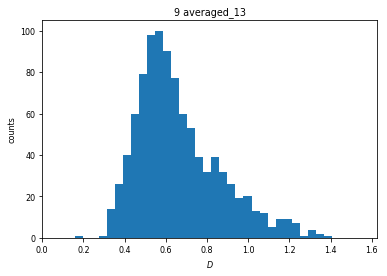

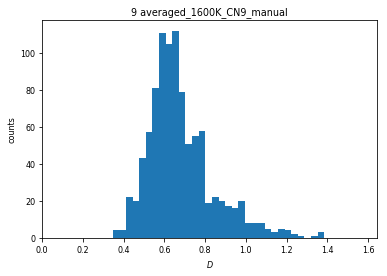

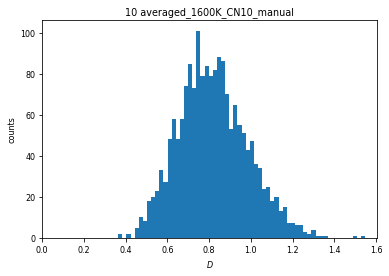

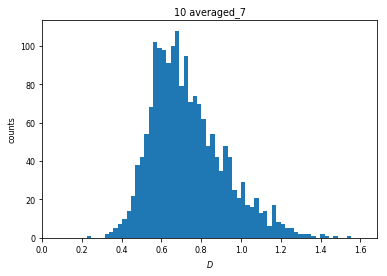

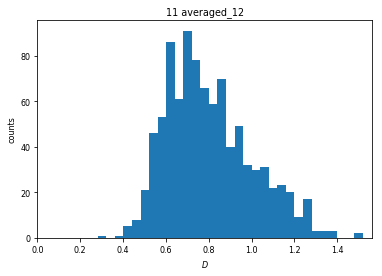

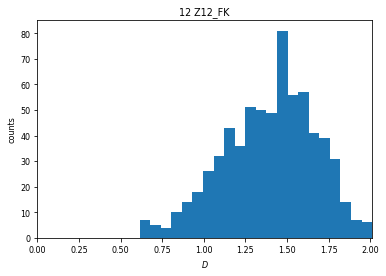

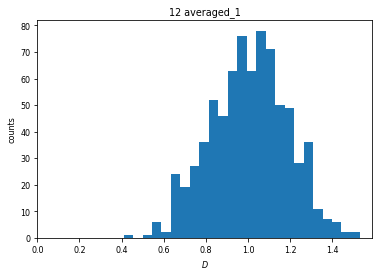

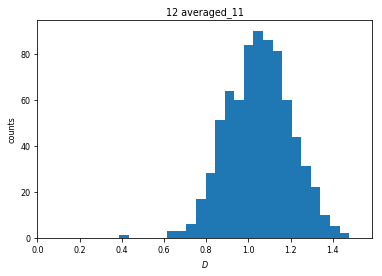

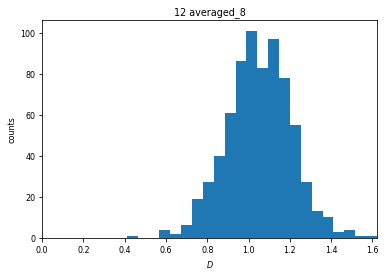

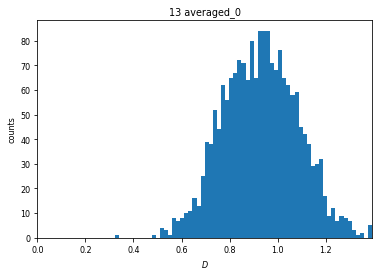

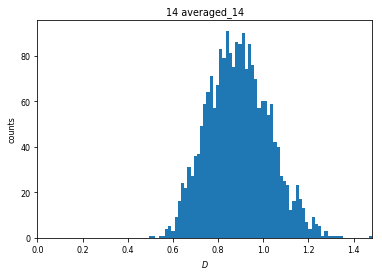

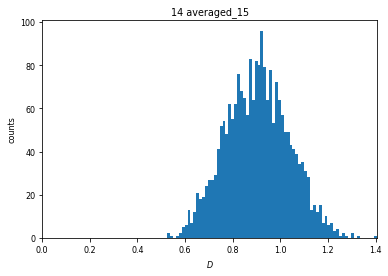

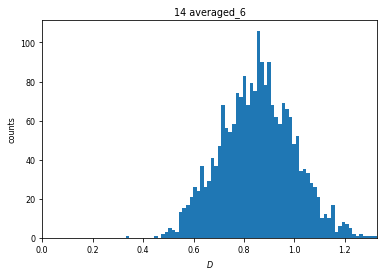

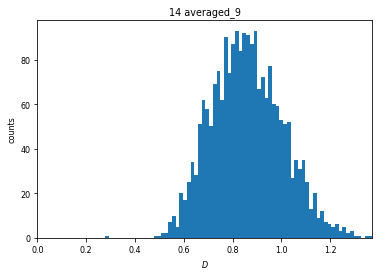

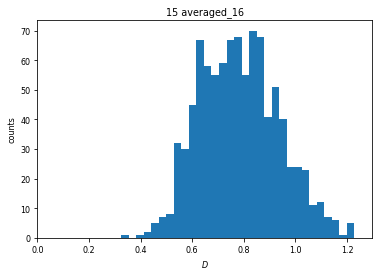

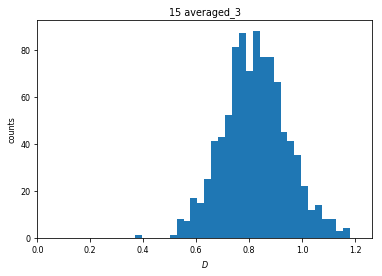

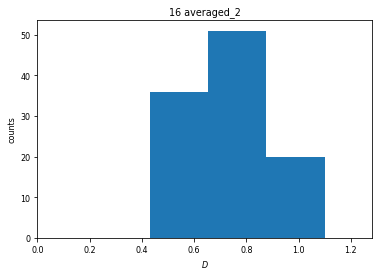

In [15]:
# Plot the distributions of the alignments to each motif. This is useful as a cursory analysis.
for motif in sorted(motifs, key=lambda motif: motif.CN):
    errors = motif.errors
    errors = errors[np.where(cluster_cns == motif.CN)]
    errors = errors[np.where(~np.isnan(errors))]
    nbins = max(int(len(errors)/30), 1)
    plt.hist(errors, bins=nbins)
    plt.title(f'{motif.CN} {motif.filename.stem}')
    plt.xlim([0, np.nanmax(motif.errors)])
    plt.xlabel(r"$D$")
    plt.ylabel("counts")
    plt.show()

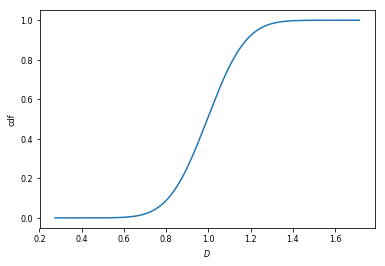

In [19]:
# Load 600K all-to-all alignment for comparison of Ds.
# This allows us to turn a given D value into a probability (see the choose_motifs notebook for more info).

# Create the gmean affinity if it doesn't exist
Ds_path = Path("../motifextraction/examples/motifextraction/metallic_glass/data/affinities/gmean.npy")
if not Ds_path.exists():
    with open("../motifextraction/examples/motifextraction/metallic_glass/data/norm_factors.json") as f:
        norm_factors = json.load(f)
    print("Loading affinity...")
    L2 = np.load("../motifextraction/examples/motifextraction/metallic_glass/data/affinities/L2_affinity.npy")
    L2[np.where(L2 > norm_factors['L2']['set_to_inf_before_dividing'])] = np.inf
    L2 /= norm_factors['L2']['divide_by']
    print("Loaded L2")

    L1 = np.load("../motifextraction/examples/motifextraction/metallic_glass/data/affinities/L1_affinity.npy")
    L1[np.where(L1 > norm_factors['L1']['set_to_inf_before_dividing'])] = np.inf
    L1 /= norm_factors['L1']['divide_by']
    print("Loaded L1")

    Linf = np.load("../motifextraction/examples/motifextraction/metallic_glass/data/affinities/Linf_affinity.npy")
    Linf[np.where(Linf > norm_factors['Linf']['set_to_inf_before_dividing'])] = np.inf
    Linf /= norm_factors['Linf']['divide_by']
    print("Loaded Linf")

    angular = np.load("../motifextraction/examples/motifextraction/metallic_glass/data/affinities/angular_affinity.npy")
    angular[np.where(angular > norm_factors['angular']['set_to_inf_before_dividing'])] = np.inf
    angular /= norm_factors['angular']['divide_by']
    print("Loaded angular")

    all_to_all_Ds_0K = scipy.stats.gmean([L2, L1, Linf, angular], axis=0)
    np.save(Ds_path, all_to_all_Ds_0K)
    assert all_to_all_Ds_0K.shape == L2.shape
    del L2, L1, Linf, angular

    print("Fitting...")
    all_to_all_Ds_0K = all_to_all_Ds_0K[np.where( (~np.isnan(all_to_all_Ds_0K)) & (~np.isinf(all_to_all_Ds_0K)) )]
    mu, sigma = scipy.stats.norm.fit(all_to_all_Ds_0K)
    del all_to_all_Ds_0K
    print("Finished")
    np.save('temp_Ds.npy', np.array([mu, sigma]))
mu, sigma = np.load('temp_Ds.npy')
Ds_norm = scipy.stats.norm(mu, sigma)

X = np.arange(mu-sigma*5, mu+sigma*5, 0.001)
Y = Ds_norm.cdf(X)
plt.xlabel("$D$")
plt.ylabel("cdf")
plt.plot(X, Y)
plt.show()

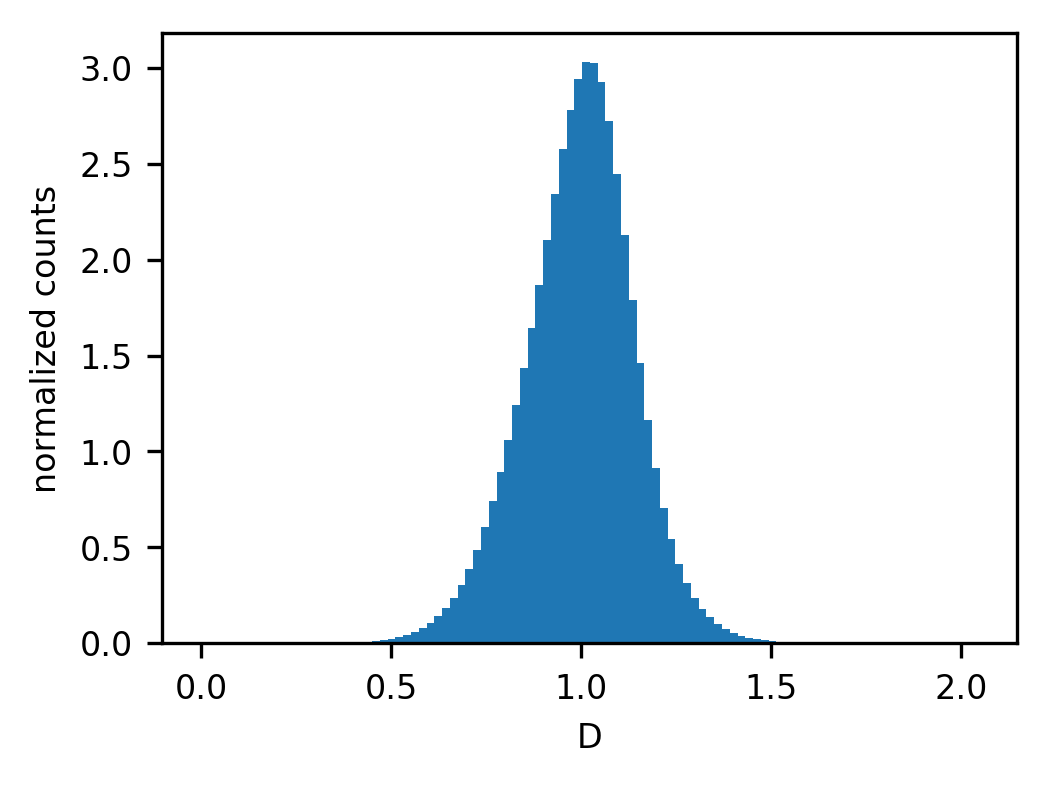

In [23]:
fig = plt.figure(figsize=compute_fig_size(9), dpi=300)
Gs = np.load(Gs_path)
Gs = Gs[np.where((~np.isnan(Gs)) & (~np.isinf(Gs)) )]
plt.hist(Gs, bins=100, density=True)
plt.xlabel("D")
plt.ylabel("normalized counts")
plt.tight_layout()
#plt.savefig("D histogram.png", dpi=fig.dpi)
plt.show()
del Gs

In [24]:
cutoff = 3.6  # Use the first valley in G(r) to set this cutoff.
def calculate_gmean(aligned_data):
    data = aligned_data
    L1, L2, Linf, angular = data.L1Norm(), data.L2Norm(), data.LinfNorm(), data.angular_variation(neighbor_cutoff=cutoff)
    L2 /= nf['L2']['divide_by']
    L1 /= nf['L1']['divide_by']
    Linf /= nf['Linf']['divide_by']
    angular /= nf['angular']['divide_by']
    g = scipy.stats.gmean((L2, L1, Linf, angular))
    return g

In [34]:
# Alignments to z-clusters
# Numbers in the first column that are close to 100% mean the motif and the z-cluster are very similar.
with open("../motifextraction/examples/motifextraction/metallic_glass/data/norm_factors.json") as f:
    nf = json.load(f)
#FK_path = Path('.../path/that/contains/z-clusters')
FK_path = Path('/home/jjmaldonis/representative-atomic-structures/final')
FKs = [Cluster(filename=fn) for fn in FK_path.glob("*.xyz")]
FKs.sort(key=lambda fk: fk.CN)
for fk in FKs:
    for motif in motifs_by_CN[fk.CN]:
        data = AlignedData.from_mapping(align(fk.filename, motif.filename))
        d = calculate_gmean(data)
        p = 1 - Ds_norm.cdf(d)
        print(round(p, 4)*100, round(d, 4), fk.filename.stem, motif.filename.stem, motif.label)
    print()


100.0 0.4017 Z9 averaged_13 $9_A$
97.78 0.7052 Z9 averaged_1600K_CN9_manual $9_B$

5.79 1.222 Z10 averaged_1600K_CN10_manual $10_A$
99.62 0.6099 Z10 averaged_7 $10_B$

99.23 0.6456 Z11_metastable_0281 averaged_12 $11_A$

100.0 0.0 Z12_FK Z12_FK $12_A$
19.06 1.1215 Z12_FK averaged_1 $12_B$
0.22 1.4064 Z12_FK averaged_11 $12_C$
0.09 1.4446 Z12_FK averaged_8 $12_D$

98.4 0.6856 Z13_VP01102 averaged_0 $13_A$

17.84 1.1281 Z14_FK averaged_14 $14_A$
97.45 0.7136 Z14_FK averaged_15 $14_B$
94.47 0.7649 Z14_FK averaged_6 $14_C$
82.94 0.8578 Z14_FK averaged_9 $14_D$

98.44 0.6841 Z15_FK averaged_16 $15_A$
96.31 0.7373 Z15_FK averaged_3 $15_B$



In [35]:
# Assign
def assign(c, motifs):
    """Assigned a cluster C to a motif. Input is the cluster index, output is the motif index.
    Constrain assignments to the same CN."""
    e = np.inf
    idx = np.nan
    for i, motif in enumerate(motifs):
        if np.abs(cluster_cns[c] - motif.CN) > 0:  # Enforce CN similarity +- 0
            continue
        if motif.errors[c] < e:
            e = motif.errors[c]
            idx = i
    return idx, e

assignments = np.zeros((NCLUSTERS))
assignments.fill(np.nan)
for c in range(NCLUSTERS):
    assignments[c] = assign(c, motifs)[0]

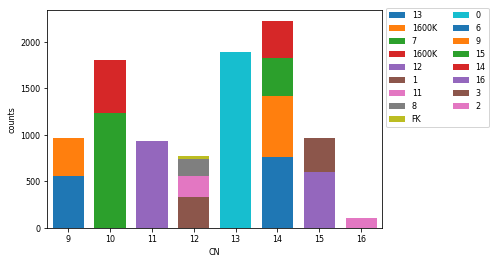

In [37]:
# Plot the number of clusters assigned to each motif

cnmin = min({motif.CN for motif in motifs})
cnmax = max({motif.CN for motif in motifs})
c = Counter(assignments[~np.isnan(assignments)].astype(int))
c_frac = Counter(assignments[~np.isnan(assignments)].astype(int))
c = Counter({motifs[i]: count for i, count in c.items()})
c_frac = Counter({motifs[i]: count for i, count in c_frac.items()})

for motif, count in c.most_common():
    #print(count, motif.filename.stem)
    cn_frac = len([motif for motif in motifs if motif.CN == motif.CN]) / float(NMOTIFS)
    c_frac[motif] = count*cn_frac

# normalize by CN distribution of the model
colors = itertools.cycle([f'C{i}' for i in range(10)])
bar_totals = defaultdict(int)
width = 0.75
for motif, count in sorted(c.most_common(), key=lambda pair: pair[0].CN):
    f = sum(cluster_cns == motif.CN)
    #label = f'{motif.CN} {motif.filename.stem.replace("_averaged", "")} {motif.vp_index[:4]}'
    label = f'{motif.filename.stem.split("_")[1]}'
    plt.bar([motif.CN], [count],
            width=width,
            bottom=[bar_totals[motif.CN]],
            color=next(colors),
            label=label
            )
    bar_totals[motif.CN] += count
    #print(motif.filename.stem, round(count / float(f) * 100, 1))
plt.xlim([cnmin - .5, cnmax +.5])
plt.legend(bbox_to_anchor=(1, 1.03), ncol=2)
plt.xlabel("CN")
plt.ylabel("counts")
plt.xticks(list(range(cnmin, cnmax+1)))
plt.show()

In [35]:
# Calculate/load the Voronoi index for each cluster
if not (data_path / "cluster_vps.npy").exists():
    vp_indices = np.zeros((NCLUSTERS, 10), dtype=np.int)
    vp_indices.fill(np.nan)

    for i in range(NCLUSTERS):
        fn = cluster_path / f'{i}.xyz'
        c = Cluster(filename=fn)
        vp_indices[i, :] = c.vp_index
        if i % 1000 == 0:
            print(i); sys.stdout.flush()
    np.save(str(data_path / "cluster_vps.npy"), vp_indices)
else:
    vp_indices = np.load(str(data_path / "cluster_vps.npy"))

In [36]:
# Print most comment VIs
c = Counter(tuple(row) for row in vp_indices)
for vp, count in c.most_common(20):
    print(count, vp, sum(vp))

883 (0, 3, 6, 0, 0, 0, 0, 0, 0, 0) 9
823 (0, 2, 8, 0, 0, 0, 0, 0, 0, 0) 10
601 (0, 2, 8, 4, 0, 0, 0, 0, 0, 0) 14
597 (0, 3, 6, 1, 0, 0, 0, 0, 0, 0) 10
574 (0, 1, 10, 2, 0, 0, 0, 0, 0, 0) 13
541 (0, 3, 6, 4, 0, 0, 0, 0, 0, 0) 13
499 (0, 2, 8, 1, 0, 0, 0, 0, 0, 0) 11
438 (0, 1, 10, 3, 0, 0, 0, 0, 0, 0) 14
337 (0, 3, 6, 5, 0, 0, 0, 0, 0, 0) 14
301 (0, 2, 8, 3, 0, 0, 0, 0, 0, 0) 13
258 (0, 1, 10, 4, 0, 0, 0, 0, 0, 0) 15
245 (0, 2, 8, 2, 0, 0, 0, 0, 0, 0) 12
237 (0, 3, 6, 3, 0, 0, 0, 0, 0, 0) 12
210 (0, 0, 12, 2, 0, 0, 0, 0, 0, 0) 14
208 (0, 2, 8, 5, 0, 0, 0, 0, 0, 0) 15
153 (0, 3, 6, 2, 0, 0, 0, 0, 0, 0) 11
145 (0, 4, 4, 6, 0, 0, 0, 0, 0, 0) 14
139 (1, 2, 5, 2, 0, 0, 0, 0, 0, 0) 10
138 (0, 3, 7, 3, 1, 0, 0, 0, 0, 0) 14
129 (0, 4, 4, 2, 0, 0, 0, 0, 0, 0) 10
